# Explainer Notebook

This notebook is structured into 4 sections:
* Motivation
* Basic Stats
* Tools, theory and analysis
* Discussion

The starting point will be numerous imports relevant for the entire notebook!

In [84]:
# imports
import requests
import os
import random
import pickle
import warnings
import nltk
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import netwulf as nw
import community as community_louvain


from bs4 import BeautifulSoup
from tqdm.auto import tqdm
from collections import defaultdict, Counter
from scipy.stats import ttest_1samp, chi2_contingency
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

warnings.filterwarnings('ignore')


## Motivation

This brief section will cover the motivation behind this project.

* What is your dataset?

The dataset behind this project is the Pokémon world, i.e. all the Pokémon found in the Pokédex using PokeAPI, and all the episodes from the Pokémon TV-show collected from Bulbapedia. Using the Pokédex, it was possible to extract all the names of each Pokémon as well as some attributes such as their type, abilities, and egg groups which are important in the games. From Bulbapedia, it was possible to scrape the plots of each episode from each season as well as lists of which Pokémon appeared in which episodes. This is relevant for graph purposes. 

* Why did you choose this/these particular dataset(s)?

We initially thought it would be interesting to go in a different direction than taking a "real-world" dataset, and see if it was still possible to apply methods from this course, and perform a relevant analysis. As such, we needed as much data from the Pokémon world as possible such that it was both possible to construct a graph with a number of attributes, and also have some text to analyse. 

* What was your goal for the end user’s experience?

The goal for the end user is to gain insight into the Pokémon world, and get a brief grasp of the different seasons, what separates them, and what makes them unique. This is the hope for someone who would come across this project. Essentially, this project can be boiled down to the following research questions:
1. Bla
2. Bla
3. Bla

These will lead the analysis done below.

## Basic Stats

Now, the focus will be shifted onto data collection and preprocessing. For this, numerous functions will be used, and these will be defined below.

In [85]:
def data_scrape():
    # scrape the data from PokéAPI
    temp_dict = {
        'pokemon': [],
        'abilities': [], 
        'types': [], 
        'egg_groups': [], 
        'moves': [],
        'pokedex_entry': []
    }
    
    for i, name in tqdm(enumerate(pokemons)):
        r = requests.get('https://pokeapi.co/api/v2/pokemon/' + str(i+1)).json()
        # append the name of the pokemon
        temp_dict['pokemon'].append(name)

        # append the abilities of the pokemon
        abilities = [r['abilities'][j]['ability']['name'] for j in range(len(r['abilities']))]
        temp_dict['abilities'].append(abilities)

        # append the types of the pokemon
        types = [r['types'][i]['type']['name'] for i in range(len(r['types']))]
        temp_dict['types'].append(types)

        # append the moves of the pokemon
        moves = [r['moves'][j]['move']['name'] for j in range(len(r['moves']))]
        temp_dict['moves'].append(moves)

        # make new request to get the egg groups and pokedex entry
        r = requests.get('https://pokeapi.co/api/v2/pokemon-species/' + str(i+1)).json()

        # append the egg groups of the pokemon
        egg_groups = [r['egg_groups'][j]['name'] for j in range(len(r['egg_groups']))]
        temp_dict['egg_groups'].append(egg_groups)

        # append the pokedex entry of the pokemon
        entry = r['flavor_text_entries'][0]['flavor_text'].replace('\n', ' ').replace('\f', ' ') if len(r['flavor_text_entries']) > 0 else None
        temp_dict['pokedex_entry'].append(entry)
        

    print('Done!')

    return temp_dict

def find_unique(df, col):
    vals = df[col].values
    all_vals = [item for sublist in vals for item in sublist]
    unique_vals = list(set(all_vals))
    return unique_vals

def get_text_entries(attribute, unique_vals):
    temp_dict = {
        attribute: [],
        'text_entry': []
    }

    for i, val in tqdm(enumerate(unique_vals)):
        r = requests.get('https://pokeapi.co/api/v2/' + attribute + '/' + val).json()
        
        # check if the text entry exists in english
        if len(r['effect_entries']) == 0:
            for j in range(len(r['flavor_text_entries'])):
                if r['flavor_text_entries'][j]['language']['name'] == 'en':
                    temp_dict[attribute].append(val)
                    temp_dict['text_entry'].append(r['flavor_text_entries'][j]['flavor_text'].replace('\n', ' ').replace('\f', ' '))
                    break
        else:
            for j in range(len(r['effect_entries'])):
                if r['effect_entries'][j]['language']['name'] == 'en':
                    temp_dict[attribute].append(val)
                    temp_dict['text_entry'].append(r['effect_entries'][j]['effect'].replace('\n', ' ').replace('\f', ' '))
                    break

    return temp_dict

In [86]:
# make the initial request to get the pokemon names
data = requests.get('https://pokeapi.co/api/v2/pokemon?limit=1000').json()['results']

# get the names of the pokemons
pokemons = []
# get the name of the pokemon
for i in range(len(data)):
    pokemons.append(data[i]['name'])

print("Check the first 5 pokemons: ", pokemons[:5])

Check the first 5 pokemons:  ['bulbasaur', 'ivysaur', 'venusaur', 'charmander', 'charmeleon']


In [87]:
# next, use the function to create the dataset (only if the file does not exist)
if not os.path.exists('pokemon.pickle'):     
    print('Scraping data...')
    poke_dict = data_scrape()
    poke_df = pd.DataFrame(poke_dict)
    poke_df.to_pickle('pokemon.pickle')
else:
    poke_df = pd.read_pickle('pokemon.pickle')
    print('Data loaded!')


Data loaded!


In [88]:
# check the info of the dataframe to get a quick overview
poke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   pokemon        1000 non-null   object
 1   abilities      1000 non-null   object
 2   types          1000 non-null   object
 3   egg_groups     1000 non-null   object
 4   moves          1000 non-null   object
 5   pokedex_entry  905 non-null    object
dtypes: object(6)
memory usage: 47.0+ KB


Now that the initial dataframe has been gathered there is a need for some cleaning. This is done in 2 simple steps:
1. Remove all NaN values. These are the entries that does not have a pokedex entry.
2. Capitalize the names of each Pokémon.

In [89]:
# first, remove NaN values
poke_df_clean = poke_df.dropna()

# second, capitalize the pokemon names
poke_df_clean['pokemon'] = poke_df_clean['pokemon'].str.capitalize()

In [90]:
# finally, we save the cleaned dataframe to a pickle file (only if the file does not exist)
poke_df_clean.to_pickle('pokemon_clean.pickle') if not os.path.exists('pokemon_clean.pickle') else print('File already exists')

File already exists


The next step is to check the unique values in each of the columns of the dataframe. This is simply to gain a quick overview of how many there are of each.

In [91]:
unique_abilities = find_unique(poke_df_clean, 'abilities')
unique_types = find_unique(poke_df_clean, 'types')
unique_egg_groups = find_unique(poke_df_clean, 'egg_groups')
unique_moves = find_unique(poke_df_clean, 'moves')
print('Number of pokemon: ', len(poke_df_clean))
print('Number of unique abilities: ', len(unique_abilities))
print('Number of unique types: ', len(unique_types))
print('Number of unique egg groups: ', len(unique_egg_groups))
print('Number of unique moves: ', len(unique_moves))

Number of pokemon:  905
Number of unique abilities:  249
Number of unique types:  18
Number of unique egg groups:  15
Number of unique moves:  747


This sums up the initial dataset preprocessing. This means that going forward, this project will only consider the 905 Pokémon found above. It is important to note that there are 249 unique abilities, 18 unique types and 15 unique egg groups, and this will become important during the graph analysis. Do however also note, there are many more combinations of these.

The next step is to collect data from all the Pokémon seasons. This process is a little more complicated, and as before it starts with defining a couple of functions.

In [92]:
def make_number(num):
    if num < 10:
        return '00' + str(num)
    elif num < 100:
        return '0' + str(num)
    else:
        return str(num)
        
def get_pokemon_data(episode, names, season):
    lookup = season_dict[season]
    r = requests.get(os.path.join('https://bulbapedia.bulbagarden.net/wiki', lookup + episode)).text
    soup = BeautifulSoup(r, 'html.parser')
    elems = soup.find_all('a', href=True)
    episode_pokemon = []

    for name in names:
        for elem in elems:
            if name in elem.text:
                text = elem.text
                episode_pokemon.append(text)

    unique_pokemon = list(set(episode_pokemon))

    # remove elements that are not single words
    unique_pokemon = [p for p in unique_pokemon if len(p.split()) == 1]

    # remove nature names
    if 'Nature' in unique_pokemon:
        unique_pokemon.remove('Nature')
    return unique_pokemon

# get episode plots
def get_episode_plot(episode, season):
    lookup = season_dict[season]
    r = requests.get(os.path.join('https://bulbapedia.bulbagarden.net/wiki', lookup + episode)).text
    soup = BeautifulSoup(r, 'html.parser')
    elems = soup.find_all('p')
    plot = ''
    for i in range(1,len(elems)):
        if "Who's That Pokémon?" in elems[i].text:
            break
        plot += elems[i].text

    #plot = plot.replace('\n ', ' ')
    plot = plot.replace('\n', ' ')

    # remove trailing whitespace
    plot = plot.strip()
    
    return plot

def gather_pokemon_data(episode_numbers, names, season):
    episode_dict = {}
    for episode in tqdm(episode_numbers):
        episode_pokemon = get_pokemon_data(episode, names, season)
        plot = get_episode_plot(episode, season)
        episode_dict[episode] = []
        episode_dict[episode].append(episode_pokemon)
        episode_dict[episode].append(plot)
    return episode_dict

In [93]:
# now, we can get the pokemon data for each episode
# first, we get the names of all pokemon from the initial dataframe
names = poke_df_clean['pokemon'].values.tolist()

In [94]:
# then, we start collecting data for each season
# this requires a bit of manual work, since the episodes are not numbered in a consistent way
# also, we need a season dict
season_dict = {
    'Indigo League': 'EP',
    'Adventures on the Orange Islands': 'EP',
    'The Johto Journeys': 'EP',
    'Hoenn': 'AG',
    'Battle Frontier': 'AG',
    'Diamond and Pearl': 'DP',
    'Black and White': 'BW',
    'XY': 'XY',
    'Sun and Moon': 'SM',
    'Pocket Monsters': 'JN'
}


In [95]:
if not os.path.exists('indigo_df.pkl'):
    print('Scraping data...')
    episode_numbers_indigo_league = [make_number(i) for i in range(1, 81)]
    indigo_dict = gather_pokemon_data(episode_numbers_indigo_league, names, 'Indigo League')
    indigo_df = pd.DataFrame.from_dict(indigo_dict, orient='index', columns=['pokemon', 'plot'])
    indigo_df.to_pickle('indigo_df.pkl')
else:
    indigo_df = pd.read_pickle('indigo_df.pkl')
    print('Data loaded!')

Data loaded!


In [96]:
if not os.path.exists('orange_df.pkl'):
    print('Scraping data...')
    episode_numbers_orange_islands = [make_number(i) for i in range(81, 117)]
    orange_dict = gather_pokemon_data(episode_numbers_orange_islands, names, 'Adventures on the Orange Islands')
    orange_df = pd.DataFrame.from_dict(orange_dict, orient='index', columns=['pokemon', 'plot'])
    orange_df.to_pickle('orange_df.pkl')
else:
    orange_df = pd.read_pickle('orange_df.pkl')
    print('Data loaded!')

Data loaded!


In [97]:
if not os.path.exists('johto_df.pkl'):
    print('Scraping data...')
    episode_numbers_johto_journeys = [make_number(i) for i in range(117, 275)]
    johto_dict = gather_pokemon_data(episode_numbers_johto_journeys, names, 'The Johto Journeys')
    johto_df = pd.DataFrame.from_dict(johto_dict, orient='index', columns=['pokemon', 'plot'])
    johto_df.to_pickle('johto_df.pkl')
else:
    johto_df = pd.read_pickle('johto_df.pkl')
    print('Data loaded!')

Data loaded!


In [98]:
if not os.path.exists('hoenn_df.pkl'):
    print('Scraping data...')
    episode_numbers_hoenn_league = [make_number(i) for i in range(1, 135)]
    hoenn_dict = gather_pokemon_data(episode_numbers_hoenn_league, names, 'Hoenn')
    hoenn_df = pd.DataFrame.from_dict(hoenn_dict, orient='index', columns=['pokemon', 'plot'])
    hoenn_df.to_pickle('hoenn_df.pkl')
else:
    hoenn_df = pd.read_pickle('hoenn_df.pkl')
    print('Data loaded!')

Data loaded!


In [99]:
if not os.path.exists('battle_df.pkl'):
    print('Scraping data...')
    episode_numbers_battle_frontier = [make_number(i) for i in range(135, 193)]
    battle_dict = gather_pokemon_data(episode_numbers_battle_frontier, names, 'Battle Frontier')
    battle_df = pd.DataFrame.from_dict(battle_dict, orient='index', columns=['pokemon', 'plot'])
    battle_df.to_pickle('battle_df.pkl')
else:
    battle_df = pd.read_pickle('battle_df.pkl')
    print('Data loaded!')

Data loaded!


In [100]:
if not os.path.exists('diamond_df.pkl'):
    print('Scraping data...')
    episode_numbers_diamond_pearl = [make_number(i) for i in range(1, 192)]
    diamond_dict = gather_pokemon_data(episode_numbers_diamond_pearl, names, 'Diamond and Pearl')
    diamond_df = pd.DataFrame.from_dict(diamond_dict, orient='index', columns=['pokemon', 'plot'])
    diamond_df.to_pickle('diamond_df.pkl')
else:
    diamond_df = pd.read_pickle('diamond_df.pkl')
    print('Data loaded!')

Data loaded!


In [101]:
if not os.path.exists('black_df.pkl'):
    print('Scraping data...')
    episode_numbers_black_white = [make_number(i) for i in range(1, 143)]
    black_dict = gather_pokemon_data(episode_numbers_black_white, names, 'Black and White')
    black_df = pd.DataFrame.from_dict(black_dict, orient='index', columns=['pokemon', 'plot'])
    black_df.to_pickle('black_df.pkl')
else:
    black_df = pd.read_pickle('black_df.pkl')
    print('Data loaded!')

Data loaded!


In [102]:
if not os.path.exists('xy_df.pkl'):
    print('Scraping data...')
    episode_numbers_xy = [make_number(i) for i in range(1, 141)]
    xy_dict = gather_pokemon_data(episode_numbers_xy, names, 'XY')
    xy_df = pd.DataFrame.from_dict(xy_dict, orient='index', columns=['pokemon', 'plot'])
    xy_df.to_pickle('xy_df.pkl')
else:
    xy_df = pd.read_pickle('xy_df.pkl')
    print('Data loaded!')

Data loaded!


In [103]:
if not os.path.exists('sun_df.pkl'):
    print('Scraping data...')
    episode_numbers_sun_moon = [make_number(i) for i in range(1, 147)]
    sun_dict = gather_pokemon_data(episode_numbers_sun_moon, names, 'Sun and Moon')
    sun_df = pd.DataFrame.from_dict(sun_dict, orient='index', columns=['pokemon', 'plot'])
    sun_df.to_pickle('sun_df.pkl')
else:
    sun_df = pd.read_pickle('sun_df.pkl')
    print('Data loaded!')

Data loaded!


In [104]:
if not os.path.exists('pocket_monsters.pkl'):
    print('Scraping data...')
    episode_numbers_pocket_monsters = [make_number(i) for i in range(1, 148)]
    pocket_dict = gather_pokemon_data(episode_numbers_pocket_monsters, names, 'Pocket Monsters')
    pocket_df = pd.DataFrame.from_dict(pocket_dict, orient='index', columns=['pokemon', 'plot'])
    pocket_df.to_pickle('pocket_monsters.pkl')
else:
    pocket_df = pd.read_pickle('pocket_monsters.pkl')
    print('Data loaded!')

Data loaded!


That was quite a bit of work!

The only thing left to do is to add a single column to each dataframe that has the season number for that dataframe, and collect the dataframes into that that then has all info.

In [105]:
# collect all the dataframes into one
frames = [indigo_df, orange_df, johto_df, hoenn_df, battle_df, diamond_df, black_df, xy_df, sun_df, pocket_df]

# add a column for the season
for i in range(len(frames)):
    frames[i]['season'] = i + 1

# combine all the dataframes
all_seasons_df = pd.concat(frames)

# save the dataframe
if not os.path.exists('all_seasons_df.pkl'):
    all_seasons_df.to_pickle('all_seasons_df.pkl')
else:
    all_seasons_df = pd.read_pickle('all_seasons_df.pkl')
    print('Data loaded!')

Data loaded!


In [106]:
# summarize the data in each season
seasons = all_seasons_df.groupby('season')
seasons.describe()

pokemon                                                                 \
         count unique                                                top freq   
season                                                                          
1           80     80  [Pikachu, Mankey, Spearow, Gyarados, Hypnosis,...    1   
2           35     35  [Poliwag, Pikachu, Mankey, Spearow, Staryu, Pi...    1   
3          158    158  [Pikachu, Chansey, Lickitung, Meowth, Fearow, ...    1   
4          134    134  [Entei, Pikachu, Mudkip, Poochyena, Beautifly,...    1   
5           58     58  [Pikachu, Rhyhorn, Manectric, Pinsir, Meowth, ...    1   
6          191    191  [Bidoof, Pikachu, Starly, Chatot, Mantyke, Meo...    1   
7          142    142  [Minccino, Pikachu, Reshiram, Deerling, Meowth...    1   
8          140    140  [Pikachu, Furret, Staryu, Pidgeotto, Lickitung...    1   
9          146    146  [Pikachu, Mankey, Litten, Staryu, Whimsicott, ...    1   
10         147    147  [Poliwag, Pikachu, Mankey, Spearow, Dugtrio, E...    1   

        plot                                                                 
       count unique                                                top freq  
season                                                                       
1         80     80  Pokémon - I Choose You! (Japanese: ポケモン！きみにきめた...    1  
2         35     35  After battling in the Pokémon League Tournamen...    1  
3        158    158  Ash begins his journey in Johto, a largely une...    1  
4        134    134  Team Rocket's failed attempt to catch Pikachu ...    1  
5         58     58  The Battle Factory is Ash's next destination—i...    1  
6        191    191  It's always exciting when new Pokémon Trainers...    1  
7        142    142  Ash excitedly arrives in the Unova region alon...    1  
8        140    140  After a quick introduction to Serena, a buddin...    1  
9        146    146  It’s a beautiful day on Melemele Island in the...    1  
10       147    147  In Pallet Town, a young Ash Ketchum is beside ...    1

Notice, these dataframes require no cleaning at all! Their purpose is simply to become the backbone of the graph creation, which is the next step in the process. What is important to notice, is that there are big differences between the seasons when it comes to the number of episodes in each. This might play role for the graphs.

The next step is to create and analyse all the graphs. 

## Tools, Theory and Analysis
### Network Analysis
The focus of the following section will first be on network analysis, after which the focus will shift onto the text related analysis. 
A lot of work was put in to building one main function that is defined below called ```graph_analysis```. This is composed of many smaller functions, and essentially all the network analysis tools that are deemed useful to our analysis. A brief overview of the function is as follows:

1. The function takes 3 arguments - a Pandas dataframe, a string variable "save_name" for plotting purposes, and a bool variable "save" that toggles whether or not the plots and analysis should be saved in folders or displayed directly in the notebook. 
2. The first important step is to construct the graph from a given dataframe. Edges between nodes (Pokémon) are made when they appear in an episode together, and this graph is weighted such that an edge between two Pokémon has a weight equal to how many episodes they appear in together. This is done with the function ```make_anime_edgelist()``` that takes the dataframe and returns an edgelist for Network X.
3. Next, attributes are added to the graph. In total there are 3, and these stem from the initial dataframe used in this project, namely ```poke_df_clean```. These are the types, the abilities, and the egg groups of the Pokémon.
4. After making the graph and adding some attributes, the first two analyses are done which are simply two plots of the degree distribution. First is a degree rank plot, and second is a histogram showing the distribution of degrees in each graph. These analyses are performed to find whether or not the distribution of degrees is heavy tailed or not.
5. Next, the 10 Pokémon with highest degree are found.
6. Afterwards, the degree assortativity coefficient is computed. This is done to find out whether or not high degree Pokémon are more likely to be connected to other high degree Pokémon and vice-versa.
7. The next analysis will test the attributes of the nodes, and explores the tendency for Pokémon to be connected to other Pokémon with shared attributes. This is done by computing the average amount of Pokémon connected to other Pokémon with shared attributes, and then shuffling the attributes randomly 100 times. This yields a distribution for each attribute that is then comparable to the average found beforehand. Also, a 1 sample t-test is computed to compare the true mean to the mean found from shuffling the attributes, and test if there is a significant difference. The functions used in this proces are: ```calc_frac```, ```frac_same_field```, and ```frac_rand_graph```.
8. The next step is a modularity analysis of the network. A partition of the network into communities is found with the ```best_partition``` implementation from ```community_louvain```, and then the modularity is computed on this partition using the ```modularity``` function from ```community_louvain```. This is done to analyse the structure of the network. 
9. Finally, the ```double_edge_swap``` algorithm is used to shuffle the connections between nodes, a partition is found once again, and the modularity is computed. This is repeated 100 times, and is used to analyse whether the modularity occurs by random or if the network is somewhat structured into modules.

This concludes the full network analysis performed in this project. Briefly, the analysis can be summarised into: degree distribution and assortativity analysis, node and attribute connection analysis, and a modularity test and analysis. These tools are used to gain a better understanding into what characterises the connection between nodes, how each graph is structured, and what the differences might be from season to season.

In [115]:
save_name_dict = {"indigo": "Indigo League",
                  "orange": "Orange Islands",
                    "johto": "Johto League",
                    "hoenn": "Hoenn League",
                    "battle": "Battle Frontier",
                    "sinnoh": "Sinnoh League",
                    "unova": "Unova League",
                    "kalos": "Kalos League",
                    "alola": "Alola League",
                    "journeys": "Pokémon Journeys",
                    "all_seasons": "All Seasons"}

def make_anime_edgelist(df):
    # make a dictionary to store the edges
    edgelist = defaultdict(lambda: 0)
    # loop over all episodes
    for i in range(len(df)):
        # loop over all pokemon in the episode
        for j in range(len(df['pokemon'].iloc[i])):
            for k in range(j+1, len(df['pokemon'].iloc[i])):
                edgelist[(df['pokemon'].iloc[i][j], df['pokemon'].iloc[i][k])] += 1
                edgelist[(df['pokemon'].iloc[i][k], df['pokemon'].iloc[i][j])] += 1

    # make the edgelist undirected 
    edgelist = [(k[0], k[1], v) for k, v in edgelist.items()]

    # only keep every other edge to avoid duplicates
    edgelist = edgelist[::2]
    return edgelist

def calc_frac(graph, fields):
    """ Calculate the fraction of neighbors with the same attribute value as the node itself."""
    fracs = []
    for node in graph.nodes:
        c = 0
        for neighbor in graph.neighbors(node):
            if fields[neighbor] == fields[node]:
                c += 1
        fracs.append(c/graph.degree(node))

    return np.mean(fracs)

def set_group(graph, group_dict):
    nx.set_node_attributes(graph, group_dict, 'group')

def frac_same_field(graph, field):
    fields = nx.get_node_attributes(graph, field)
    return calc_frac(graph, fields)

def frac_rand_graph(graph, field):
    fields = nx.get_node_attributes(graph, field)
    field_list = list(fields.values())
    for key in fields.keys():
        fields[key] = random.choice(field_list)

    return calc_frac(graph, fields)

# we use the same seed as before to ensure reproducibility
def modularity_test(graph, nswap):
    temp_graph = nx.double_edge_swap(graph, nswap=nswap, max_tries=1000000)
    partition = community_louvain.best_partition(temp_graph)
    return community_louvain.modularity(partition, temp_graph)

# time to make a function for all graph analysis
def graph_analysis(df, save_name: str, save: bool = False):
    # setup relevant folders for saving
    if save:
        os.makedirs(f'figures/{save_name}', exist_ok=True)
        os.makedirs('graphs', exist_ok=True)
        os.makedirs('txt_files', exist_ok=True)

    # make a list to store the text
    if save:
        txt_lines = []

    # make big print statement
    if save:
        txt_lines.append("Analysing the graph for the " + save_name_dict[save_name] + " season") 
    else: 
        print(f"Analysing the graph for the {save_name_dict[save_name]} season")
    # make the initial graph
    G = nx.Graph()
    print(f"Making graph for {save_name_dict[save_name]} season...")
    G.add_weighted_edges_from(make_anime_edgelist(df))
    print("Done!")
    
    if save:
        txt_lines.append(f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    else:
        print(f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # make dataframe with only pokemon in original df
    anime_pokemon = find_unique(df, 'pokemon')
    anime_pokemon_df = poke_df_clean[poke_df_clean['pokemon'].isin(anime_pokemon)].reset_index(drop=True)

    # remove all nodes that are not in the anime pokemon dataframe
    pokemon = anime_pokemon_df['pokemon'].values.tolist()
    G.remove_nodes_from([n for n in G.nodes() if n not in pokemon])

    # add pokemon attributes to graph
    types = [t for t in anime_pokemon_df['types'].values]
    type_dict = dict(zip(anime_pokemon_df['pokemon'], types))

    abilities = [a for a in anime_pokemon_df['abilities'].values]
    ability_dict = dict(zip(anime_pokemon_df['pokemon'], abilities))

    egg_groups = [e for e in anime_pokemon_df['egg_groups'].values]
    egg_group_dict = dict(zip(anime_pokemon_df['pokemon'], egg_groups))

    nx.set_node_attributes(G, type_dict, 'types')
    nx.set_node_attributes(G, ability_dict, 'abilities')
    nx.set_node_attributes(G, egg_group_dict, 'egg_groups')

    # degree rank plot
    degree_sequence = sorted([d for _, d in G.degree()], reverse=True)

    # do a rank plot and histrogram as subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(degree_sequence, 'b-', marker='o')
    ax1.set_title(f"Degree rank plot for {save_name_dict[save_name]}")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("rank")
    ax2.hist(degree_sequence, bins=20)
    ax2.axvline(np.mean(degree_sequence), color='r', linestyle='dashed', linewidth=1)
    ax2.text(np.mean(degree_sequence) + 0.5, 0.5, f"Mean: {np.mean(degree_sequence):.2f}")
    ax2.set_title(f"Histogram of degree distribution for {save_name_dict[save_name]}")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Count")
    fig.tight_layout()
    figure_path = os.path.join('figures', save_name, 'degree_plots.png')
    
    if save:
        plt.savefig(figure_path)
        plt.close()
    else:
        plt.show()

    # identify the ten pokemon with the highest degree
    sorted_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
    # print the top ten pokemon with the highest degree and their degree value each on one line
    if save:
        txt_lines.append("The top ten pokemon with the highest degree are:")
    else:
        print("The top ten pokemon with the highest degree are:")
        
    for i in range(10):
        if save:
            txt_lines.append(f"{sorted_degree[i][0]}: {sorted_degree[i][1]}")
        else:
            print(f"{sorted_degree[i][0]}: {sorted_degree[i][1]}")

    # get degree assortativity
    dac = nx.degree_assortativity_coefficient(G)
    if save:
        txt_lines.append(f"The degree assortativity coefficient is {dac:.2f}")
    else:
        print(f"The degree assortativity coefficient is {dac:.2f}")

    # explore connections between pokemon types, abilities and egg groups
    avg_typing = frac_same_field(G, 'types')
    avg_abilities = frac_same_field(G, 'abilities')
    avg_egg_groups = frac_same_field(G, 'egg_groups')
    avg_rand_type_100 = [frac_rand_graph(G, 'types') for _ in range(100)]
    avg_rand_type_100_mu = np.mean(avg_rand_type_100)
    avg_rand_abilities_100 = [frac_rand_graph(G, 'abilities') for _ in range(100)]
    avg_rand_abilities_100_mu = np.mean(avg_rand_abilities_100)
    avg_rand_egg_groups_100 = [frac_rand_graph(G, 'egg_groups') for _ in range(100)]
    avg_rand_egg_groups_100_mu = np.mean(avg_rand_egg_groups_100)
    if save:
        txt_lines.append(f"The average fraction of neighbors with the same typing as the node itself is {avg_typing*100:.2f}%")    
        txt_lines.append(f"The average fraction of neighbors with the same ability as the node itself is {avg_abilities*100:.2f}%")
        txt_lines.append(f"The average fraction of neighbors with the same egg group as the node itself is {avg_egg_groups*100:.2f}%")
        txt_lines.append(f"The average fraction of neighbors with the same typing as the node itself when random is {avg_rand_type_100_mu*100:.2f}%")
        txt_lines.append(f"The average fraction of neighbors with the same ability as the node itself when random is {avg_rand_abilities_100_mu*100:.2f}%")    
        txt_lines.append(f"The average fraction of neighbors with the same egg group as the node itself when random is {avg_rand_egg_groups_100_mu*100:.2f}%")
    else:
        print(f"The average fraction of neighbors with the same typing as the node itself is {avg_typing*100:.2f}%")
        print(f"The average fraction of neighbors with the same ability as the node itself is {avg_abilities*100:.2f}%")
        print(f"The average fraction of neighbors with the same egg group as the node itself is {avg_egg_groups*100:.2f}%")
        print(f"The average fraction of neighbors with the same typing as the node itself when random is {avg_rand_type_100_mu*100:.2f}%")
        print(f"The average fraction of neighbors with the same ability as the node itself when random is {avg_rand_abilities_100_mu*100:.2f}%")
        print(f"The average fraction of neighbors with the same egg group as the node itself when random is {avg_rand_egg_groups_100_mu*100:.2f}%")

    # now we make three subplots of the random distributions with the actual values plotted as vertical lines with text
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    ax[0].hist(avg_rand_type_100, bins=20)
    ax[0].axvline(avg_typing, color='r', linestyle='dashed', linewidth=1)
    ax[0].set_title("Typing")
    ax[0].set_ylabel("Count")
    ax[0].set_xlabel("Fraction of neighbors with same typing")
    ax[1].hist(avg_rand_abilities_100, bins=20)
    ax[1].axvline(avg_abilities, color='r', linestyle='dashed', linewidth=1)
    ax[1].set_title("Abilities")
    ax[1].set_xlabel("Fraction of neighbors with same ability")
    ax[2].hist(avg_rand_egg_groups_100, bins=20)
    ax[2].axvline(avg_egg_groups, color='r', linestyle='dashed', linewidth=1)
    ax[2].set_title("Egg Groups")
    ax[2].set_xlabel("Fraction of neighbors with same egg group")
    
    plt.suptitle(f"Random distributions for {save_name_dict[save_name]}")
    if save:
        plt.savefig(os.path.join('figures', save_name, 'random_distributions.png'))
        plt.close()
    else:
        plt.show()

    # make statistical tests for the three fields
    p_val_typing = ttest_1samp(avg_rand_type_100, avg_typing)[1]
    p_val_abilities = ttest_1samp(avg_rand_abilities_100, avg_abilities)[1]
    p_val_egg_groups = ttest_1samp(avg_rand_egg_groups_100, avg_egg_groups)[1]
    if save:
        txt_lines.append("Statistical tests for the three fields:")    
        txt_lines.append(f"Typing: {p_val_typing}")    
        txt_lines.append(f"Abilities: {p_val_abilities}")    
        txt_lines.append(f"Egg Groups: {p_val_egg_groups}")
    else:
        print("Statistical tests for the three fields:")
        print(f"Typing: {p_val_typing}")
        print(f"Abilities: {p_val_abilities}")
        print(f"Egg Groups: {p_val_egg_groups}")

    # find best partition
    partition = community_louvain.best_partition(G)
    # print the modularity
    mod = community_louvain.modularity(partition, G)
    if save:
        txt_lines.append(f"The modularity is {mod:.2f}")
    else:
        print(f"The modularity is {mod:.2f}")

    num_communities = len(set(partition.values()))
    if save:
        txt_lines.append(f"There are {num_communities} communities")
    else:
        print(f"There are {num_communities} communities")

    # Community sizes
    community_sizes = [len(list(filter(lambda x: x[1] == i, partition.items()))) for i in range(num_communities)]
    if save:
        txt_lines.append(f"The community sizes are {community_sizes}")
    else:
        print(f"The community sizes are {community_sizes}")

    # find the top 5 pokemon in each community ordered by degree
    top_5 = []
    for i in range(num_communities):
        community = list(filter(lambda x: x[1] == i, partition.items()))
        community.sort(key=lambda x: G.degree[x[0]], reverse=True)
        top_5.append(community[:5])
    if save:
        txt_lines.append("The top 5 pokemon in each community are:")
        for i, community in enumerate(top_5):
            txt_lines.append(f"Community {i+1}:")
            for pokemon in community:
                txt_lines.append(f"{pokemon[0]}")
    else:
        print("The top 5 pokemon in each community are:")
        for i, community in enumerate(top_5):
            print(f"Community {i+1}:")
            # print all 5 on one line
            print(', '.join([pokemon[0] for pokemon in community]))

    # add the community as an attribute to the nodes
    set_group(G, partition)

    # save the final graph
    with open(os.path.join('graphs', f'{save_name}_G.pkl'), 'wb') as f:
        pickle.dump(G, f)

    # time to test modularity
    if save:
        txt_lines.append("Testing modularity")
    print("Testing modularity")
    if save_name != 'all_seasons':
        # if we are using the all seasons graph, we need to remove the edges between seasons
        
        mods = []
        for _ in range(100):
            mods.append(modularity_test(G, G.number_of_edges()/2))
        if save:
            txt_lines.append(f"The average modularity after double edge swap test is {np.mean(mods):.2f}")
        else:
            print(f"The average modularity after double edge swap test is {np.mean(mods):.2f}")
        # statistical test
        p_val_mod = ttest_1samp(mods, mod)[1]
        if save:
            txt_lines.append(f"The p-value for the modularity test is {p_val_mod}")
        else:
            print(f"The p-value for the modularity test is {p_val_mod}")

        # plot the distribution of modularity values with the actual modularity value plotted as a vertical line
        plt.figure(figsize=(5, 3))
        plt.hist(mods, bins=20)
        plt.axvline(mod, color='r', linestyle='dashed', linewidth=1)
        plt.title(f"Modularity distribution for {save_name_dict[save_name]}")
        plt.xlabel("Modularity")
        plt.ylabel("Count")
        if save:
            plt.savefig(os.path.join('figures', save_name, 'modularity_distribution.png'))
            plt.close()
        else:
            plt.show()

    # write all the text lines to a file
    if save:
        with open(os.path.join('txt_files', f'{save_name}_text.txt'), 'w') as f:
            f.write('\n'.join(txt_lines))
    

In [116]:
# make the graphs
name_to_df_dict = {"indigo": indigo_df,
                   "orange": orange_df,
                   "johto": johto_df,
                   "hoenn": hoenn_df,
                   "sinnoh": diamond_df,
                   "unova": black_df,
                   "kalos": xy_df,
                   "alola": sun_df,
                   "journeys": pocket_df,
                   "all_seasons": all_seasons_df
}

# loop through all the dataframes and make the graphs in parallel (once this is done once, it can be commented out)
with Parallel(n_jobs=-1) as parallel:
    parallel(
        delayed(graph_analysis)(df, name, save=True)
        for name, df in tqdm(name_to_df_dict.items(), desc="Making graphs")
    )

Making graphs: 100%|██████████| 10/10 [00:00<00:00, 24.63it/s]


Making graph for Indigo League season...
Making graph for Orange Islands season...
Making graph for Johto League season...
Making graph for Hoenn League season...
Making graph for Sinnoh League season...
Making graph for Unova League season...
Making graph for Kalos League season...
Making graph for Alola League season...
Done!
Done!
Done!
Done!
Done!
Testing modularity
Done!
Done!
Testing modularity
Done!
Testing modularity
Testing modularity
Testing modularity
Testing modularity
Testing modularity
Testing modularity
Making graph for Pokémon Journeys season...
Done!
Testing modularity
Making graph for All Seasons season...
Done!
Testing modularity


Analysing the graph for the Indigo League season
Making graph for Indigo League season...


100%|██████████| 80/80 [00:01<00:00, 71.13it/s] 


Done!
The graph has 153 nodes and 5250 edges


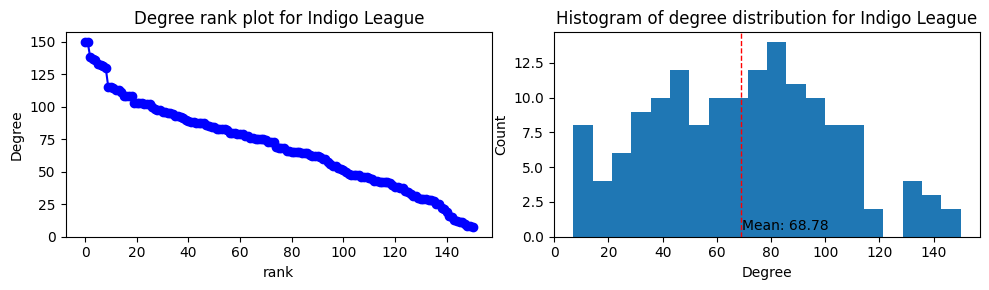

The top ten pokemon with the highest degree are:
Pikachu: 150
Meowth: 150
Pidgeotto: 138
Bulbasaur: 137
Squirtle: 136
Weezing: 133
Charmander: 132
Togepi: 131
Arbok: 130
Starmie: 115
The degree assortativity coefficient is -0.20
The average fraction of neighbors with the same typing as the node itself is 6.56%
The average fraction of neighbors with the same ability as the node itself is 1.56%
The average fraction of neighbors with the same egg group as the node itself is 7.47%
The average fraction of neighbors with the same typing as the node itself when random is 4.83%
The average fraction of neighbors with the same ability as the node itself when random is 1.24%
The average fraction of neighbors with the same egg group as the node itself when random is 6.05%


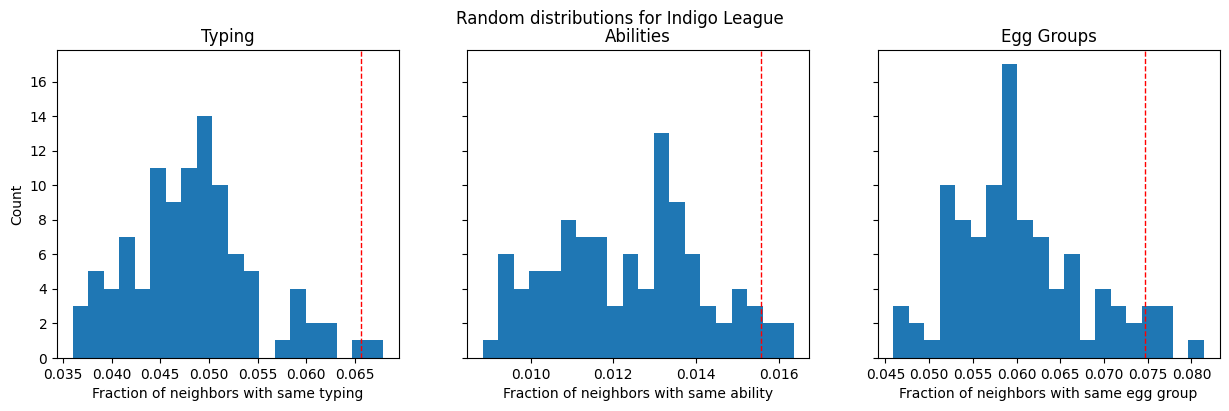

Statistical tests for the three fields:
Typing: 9.083451389219413e-48
Abilities: 7.148884908743902e-32
Egg Groups: 3.8346322764710558e-34
The modularity is 0.10
There are 4 communities
The community sizes are [56, 49, 18, 28]
The top 5 pokemon in each community are:
Community 1:
Pikachu, Meowth, Pidgeotto, Bulbasaur, Squirtle
Community 2:
Charizard, Raticate, Poliwhirl, Jigglypuff, Tauros
Community 3:
Oddish, Chansey, Pidgey, Spearow, Voltorb
Community 4:
Krabby, Muk, Persian, Bellsprout, Mewtwo
Testing modularity


  9%|▉         | 9/100 [00:07<01:11,  1.28it/s]


KeyboardInterrupt: 

In [ ]:
# do graph analysis for indigo
graph_analysis(indigo_df, 'indigo', save=False)

,pokemon,plot,season
001,"[Pikachu, Mankey, Spearow, Gyarados, Hypnosis,...",Pokémon - I Choose You! (Japanese: ポケモン！きみにきめた...,1
002,"[Goldeen, Pikachu, Rattata, Jigglypuff, Caterp...",Ash rushes into Viridian City with his gravely...,1
003,"[Pikachu, Caterpie, Beedrill, Ekans, Pidgeotto...",Ash discovers and catches a Caterpie—his first...,1
004,"[Pikachu, Bulbasaur, Charmander, Beedrill, Pin...",Misty and Ash continue to wander the Viridian ...,1
005,"[Geodude, Pikachu, Pidgeotto, Meowth, Butterfr...","Jessie, James, and Meowth dig a trap for our h...",1
...,...,...,...
143,"[Pikachu, Mantyke, Meowth, Gyarados, Latias, W...",Ash and his friends are watching some Wailmer ...,10
144,"[Pikachu, Furret, Rotom, Chansey, Meowth, Lati...",Ash and his friends arrive at a small town at ...,10
145,"[Yamask, Yanmega, Pikachu, Slakoth, Staryu, Li...","While traveling along a road, Ash and his frie...",10
146,"[Pikachu, Spinarak, Spearow, Beartic, Meowth, ...",Following the vision of a Latios shown to them...,10


### Text Analysis
The following section will contain all steps to the text analysis